In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os, sys

sys.path.append("..")
from modules.utils import paper_style
from sklearn.metrics import r2_score

paper_style()

from helper_fn import *

sys.path.append("..")

# from modules.utils import paper_style

# loading GT stuff

# current_dir = os.path.dirname(os.path.abspath(__file__))
current_dir = ""
relative_path = "../data"
path = os.path.join(current_dir, relative_path)
gt_path = os.path.join(path, "GT/")
gt_drug_path = os.path.join(path, "GT_drug/labels/")


gt_tracks = []
gt_drug_tracks = []
taus = []
taus_drugs = []
for i, fn in enumerate(os.listdir(gt_path)):
    track = np.load(os.path.join(gt_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_tracks.append(track)
    taus.append(tau)

for i, fn in enumerate(os.listdir(gt_drug_path)):
    track = np.load(os.path.join(gt_drug_path, fn)).squeeze().T
    tau = np.linspace(0, 1, track.shape[0])
    gt_drug_tracks.append(track)
    taus_drugs.append(tau)


# tr_green = 0.035
# tr_phase_green = 0.15

tr_green = 0.10
tr_phase_green = 0.4

crossing_points_gt, idx_gt = find_crossing_points(taus, gt_tracks)
crossing_points_drugs, idx_drugs = find_crossing_points(
    taus_drugs,
    gt_drug_tracks,
    drug=True,
    tr_green=tr_green,
    tr_phase_green=tr_phase_green,
)

track_lengths = [track.shape[0] for track in gt_tracks]
track_lengths_drugs = [track.shape[0] for track in gt_drug_tracks]

In [2]:
idx_gt.mean(0)[0]

def mean_len_phases(gt):
    len_g1 = np.nanmean(gt, axis=0)[0] * 5
    len_s = (np.nanmean(gt, axis=0)[1] - np.nanmean(gt, axis=0)[0]) * 5

    return len_g1, len_s

mean_len_g1, mean_len_s = mean_len_phases(idx_gt)
mean_len_g1_drugs, mean_len_s_drugs = mean_len_phases(idx_drugs)

In [3]:
print(f"len G1: {mean_len_g1:.2f}, len S: {mean_len_s:.2f}")
print(f"len G1 drugs: {mean_len_g1_drugs:.2f}, len S drugs: {mean_len_s_drugs:.2f}")

len G1: 394.08, len S: 414.57
len G1 drugs: 1478.97, len S drugs: 590.48


In [4]:

len_g1 = idx_gt[:, 0] * 5/60
len_s = (idx_gt[:, 1] - idx_gt[:, 0]) * 5/60

len_g1_drugs = idx_drugs[:, 0] * 5/60
len_s_drugs = (idx_drugs[:, 1] - idx_drugs[:, 0]) * 5/60

track_lengths = np.array(track_lengths)
track_lengths_drugs = np.array(track_lengths_drugs)

len_g2m = 5/60* track_lengths  - len_g1 - len_s

len_g2m_drugs = 5/60* track_lengths_drugs  - len_g1_drugs - len_s_drugs



# remove nans
len_g1 = len_g1[~np.isnan(len_g1)]
len_s = len_s[~np.isnan(len_s)]
len_g2m = len_g2m[~np.isnan(len_g2m)]
len_g1_drugs = len_g1_drugs[~np.isnan(len_g1_drugs)]
len_s_drugs = len_s_drugs[~np.isnan(len_s_drugs)]
len_g2m_drugs = len_g2m_drugs[~np.isnan(len_g2m_drugs)]




In [5]:
def paper_style():
    plt.rcParams.update(
        {
            "figure.figsize": (7, 5),  # Default figure size (width, height) in inches
            "axes.titlesize": 18,  # Title font size
            "axes.labelsize": 16,  # Axis label font size
            "xtick.labelsize": 11,  # X-tick label font size
            "ytick.labelsize": 11,  # Y-tick label font size
            "legend.fontsize": 14,  # Legend font size
            "legend.title_fontsize": 16,  # Legend title font size
            # 'font.family': 'serif',              # Font family (you can change this to 'sans-serif' or 'monospace')
            # 'font.serif': ['Times New Roman'],   # Font choice, adjust to your needs
            "axes.linewidth": 1.5,  # Width of the axis lines
            "lines.linewidth": 2.5,  # Line width for plots
            "axes.spines.top": True,  # Disable top spine
            "axes.spines.right": True,  # Disable right spine
            "legend.frameon": False,  # Disable legend box
            "savefig.dpi": 300,  # Set DPI for saving figures, important for publication-quality figures
            "savefig.format": "pdf",  # Default file format when saving figures
        }
    )
paper_style()

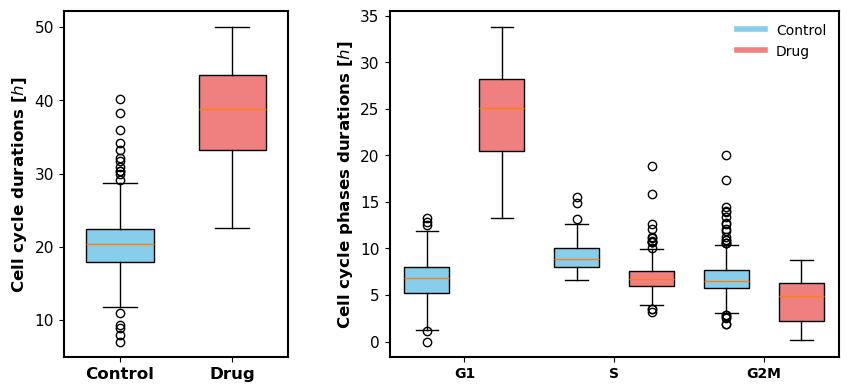

In [17]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Define the colors for Control and Drug
ctrl_color = "skyblue"
drug_color = "lightcoral"

# Create the figure with two subplots using constrained layout
fig, axs = plt.subplots(1, 2, figsize=(10, 4.5), gridspec_kw={'width_ratios': [0.5, 1], 'wspace': 0.3})

# First plot: Track lengths boxplot
box_ctrl = axs[0].boxplot([ 5/60*track_lengths,  5/60*track_lengths_drugs], widths=0.6, patch_artist=True)
# Color the boxes individually
for patch, label in zip(box_ctrl['boxes'], ["Control", "Drug"]):
    patch.set_facecolor(ctrl_color if label == "Control" else drug_color)
axs[0].set_xticks([1, 2])
axs[0].set_xticklabels(["Control", "Drug"], fontsize=12, fontweight='bold')
axs[0].set_ylabel("Cell cycle durations [$h$]", fontsize=12, fontweight='bold')

# Second plot: Cell cycle phase lengths boxplot
box_ctrl_drug = axs[1].boxplot(
    [len_g1, len_g1_drugs, len_s_drugs, len_s, len_g2m, len_g2m_drugs],
    widths=0.6, patch_artist=True
)
# Color the boxes individually
for patch, label in zip(box_ctrl_drug['boxes'], 
                        ["G1", "G1 drugs", "S", "S drugs", "G2M", "G2M drugs"]):
    patch.set_facecolor(ctrl_color if "drug" not in label else drug_color)
    
axs[1].set_xticks([1.5, 3.5, 5.5])
axs[1].set_xticklabels(["G1", "S", "G2M"], fontsize=10, fontweight='bold')
axs[1].set_ylabel("Cell cycle phases durations [$h$]", fontsize=12, fontweight='bold')

# Create custom legend
legend_elements = [Line2D([0], [0], color=ctrl_color, lw=4, label="Control"),
                   Line2D([0], [0], color=drug_color, lw=4, label="Drug")]
axs[1].legend(handles=legend_elements, loc='upper right', fontsize=10)

# Make the contour of the squares (spines) thicker in both subplots
for ax in axs:
    for spine in ax.spines.values():
        spine.set_linewidth(1.5)

# Save and show the figure
plt.savefig('Track_lengths_and_Cell_cycle_phases.png', transparent=True)
plt.show()
